# Import the libraries

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Load data, data transformation and merge them

In [59]:
errands_df =pd.read_parquet("Data/errands.parquet")
orders_df =pd.read_parquet("Data/orders.parquet")

In [60]:
errands_df['order_number'] = errands_df['order_number'].apply(lambda x: str(int(x, 36)))
orders_df['order_id'] = orders_df['order_id'].astype(str)

errands_df['errand_created_at'] = pd.to_datetime(errands_df['created'])
orders_df['order_created_at'] = pd.to_datetime(orders_df['order_created_at'])

In [61]:
# Merge datasets using the converted order numbers
merged_df = pd.merge(
        errands_df,
        orders_df,
        left_on='order_number',
        right_on='order_id',
        how='inner'
    )
merged_df.shape
merged_df.head(3)

,order_number,errand_id,created,errand_category,errand_type,errand_action,errand_channel,is_test_errand,errand_created_at,order_id,...,Device,client_entry_type,booking_system_source_type,Origin_Country,Destination_Country,Journey_Type_ID,Is_Changed,Is_Canceled,cancel_reason,change_reason
0,4607513832,52497975,2023-12-31 08:59:49,6: Payment questions,2: Payment not conf - CC,1: Info provided,1: Phone In,0,2023-12-31 08:59:49,4607513832,...,iPhone,metasearch,API,Japan,Japan,One-way,1,1,Tech error - ticket,Cancel part of order
1,4607513832,52532186,2024-01-01 09:37:35,5: Document & travel info,5: Itinerary questions,1: Info provided,1: Phone In,1,2024-01-01 09:37:35,4607513832,...,iPhone,metasearch,API,Japan,Japan,One-way,1,1,Tech error - ticket,Cancel part of order
2,4607513832,52532297,2024-01-01 09:40:10,5: Document & travel info,5: Itinerary questions,1: Info provided,1: Phone In,0,2024-01-01 09:40:10,4607513832,...,iPhone,metasearch,API,Japan,Japan,One-way,1,1,Tech error - ticket,Cancel part of order


# checking missing values and if there is any duplicates

In [62]:
print(merged_df.isnull().sum())

order_number                     0
errand_id                        0
created                          0
errand_category                  0
errand_type                      3
errand_action                 2338
errand_channel                   0
is_test_errand                   0
errand_created_at                0
order_id                         0
PNR                              0
order_created_at                 0
booking_system                   0
Site_Country                     0
Brand                            0
Order_Amount                     0
currency                         0
Revenue                          0
Partner                          0
Customer_Group_Type              0
Device                           0
client_entry_type                0
booking_system_source_type       0
Origin_Country                   0
Destination_Country              0
Journey_Type_ID                  0
Is_Changed                       0
Is_Canceled                      0
cancel_reason       

In [55]:
merged_df.duplicated().sum()


0

# Exploratory Data Analysis (EDA)

# Distribution of Contacts per Order

Average contacts per order: 2.81


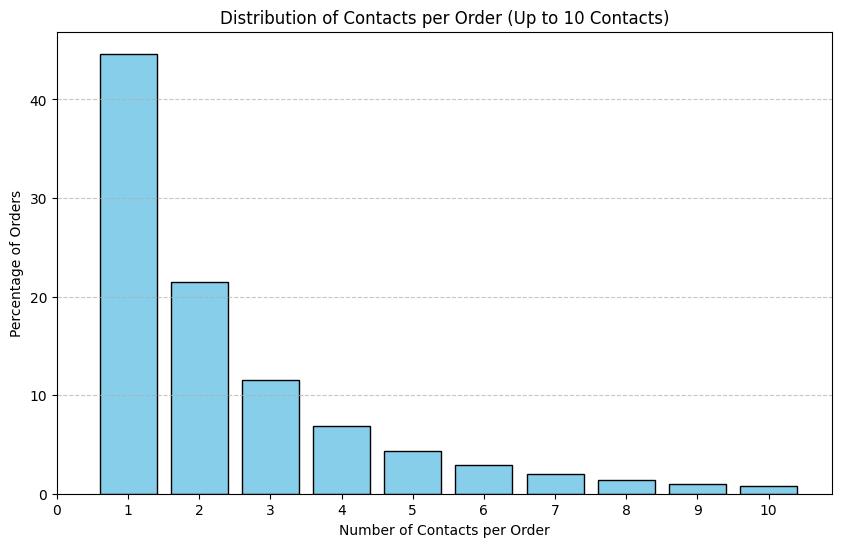

In [15]:
# Calculate the number of contacts per order
contacts_per_order = merged_df.groupby('order_number').size()

# Compute the average contacts per order
average_contacts = contacts_per_order.mean()
print(f"Average contacts per order: {average_contacts:.2f}")

# Get the distribution of contacts per order and calculate percentages
distribution = contacts_per_order.value_counts().sort_index()
percentages = (distribution / len(contacts_per_order) * 100)

# Optional: Visualize the distribution
plt.figure(figsize=(10, 6))
plt.bar(percentages[percentages.index <= 10].index,
        percentages[percentages.index <= 10].values,
        color='skyblue', edgecolor='black')
plt.xlabel('Number of Contacts per Order') 
plt.ylabel('Percentage of Orders')
plt.title('Distribution of Contacts per Order (Up to 10 Contacts)')
plt.xticks(range(0, 11))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Channel Effectiveness Analysis
### aim:Highlight preferred and effective channels, optimize staffing and training, and consider shifting efforts to cost-effective channels.

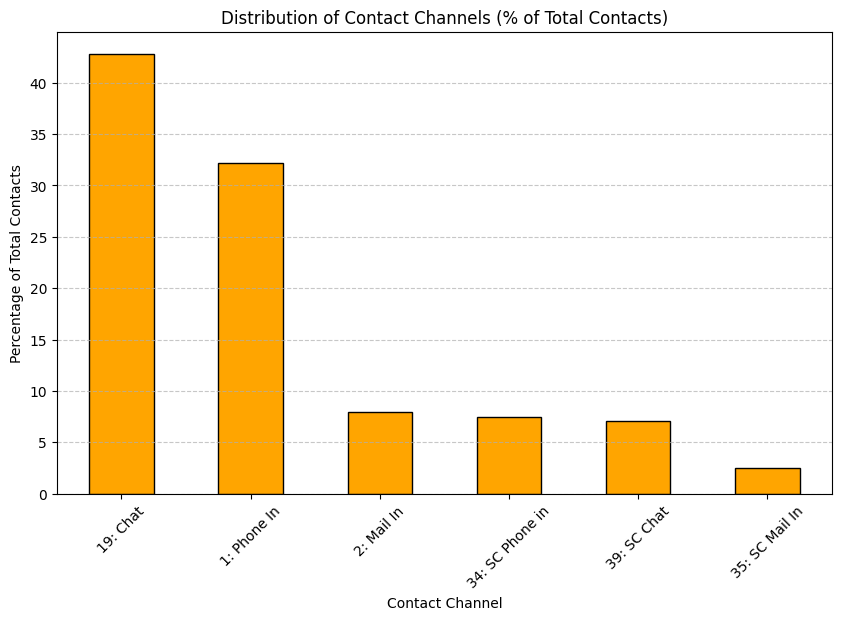

In [94]:
# Calculate the distribution of contact channels
channel_distribution = merged_df['errand_channel'].value_counts()
percentages = (channel_distribution / len(merged_df)) * 100

# Optional: Visualize the distribution
percentages.plot(kind='bar', figsize=(10, 6), color='orange', edgecolor='black')
plt.xlabel('Contact Channel')
plt.ylabel('Percentage of Total Contacts')
plt.title('Distribution of Contact Channels (% of Total Contacts)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Analyze Errand Categories/Types and Errand Action
### aim: Identify the primary customer pain points (e.g., payment issues, rebooking) and focus improvement efforts there.

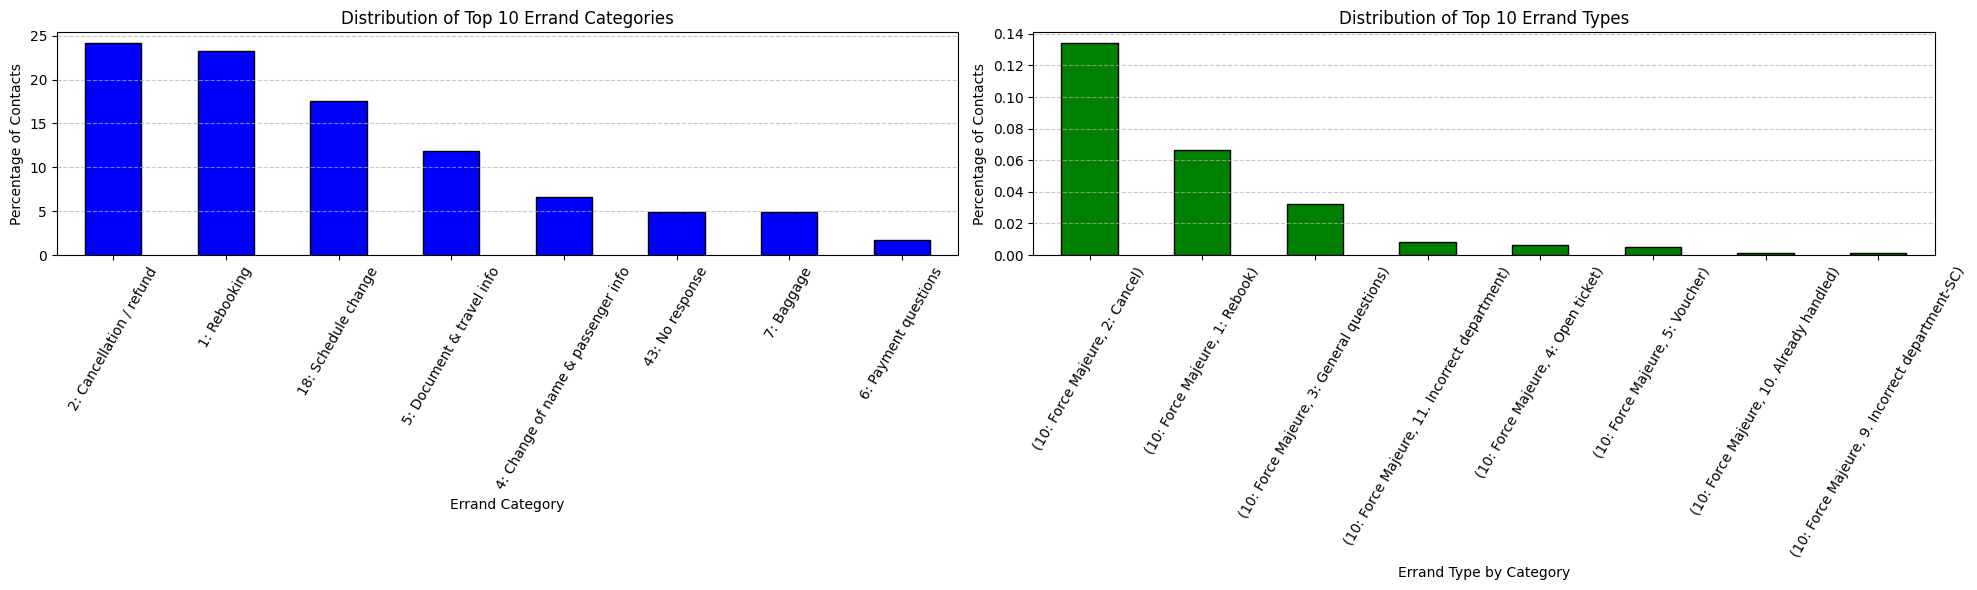

In [84]:
# Analyze top errand categories and types
category_distribution = merged_df['errand_category'].value_counts()
category_percentage = (category_distribution / category_distribution.sum()) * 100

type_distribution = merged_df.groupby('errand_category')['errand_type'].value_counts()
type_percentage = (type_distribution / type_distribution.sum()) * 100




# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot category distribution (top 10)
category_percentage.head(8).plot(kind='bar', color='blue', edgecolor='black', ax=ax1)
ax1.set_xlabel('Errand Category')
ax1.set_ylabel('Percentage of Contacts')
ax1.set_title('Distribution of Top 10 Errand Categories')
ax1.tick_params(axis='x', rotation=60)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Plot type distribution (top 10 types)
type_percentage.head(8).plot(kind='bar', color='green', edgecolor='black', ax=ax2)
ax2.set_xlabel('Errand Type by Category')
ax2.set_ylabel('Percentage of Contacts')
ax2.set_title('Distribution of Top 10 Errand Types')
ax2.tick_params(axis='x', rotation=60)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


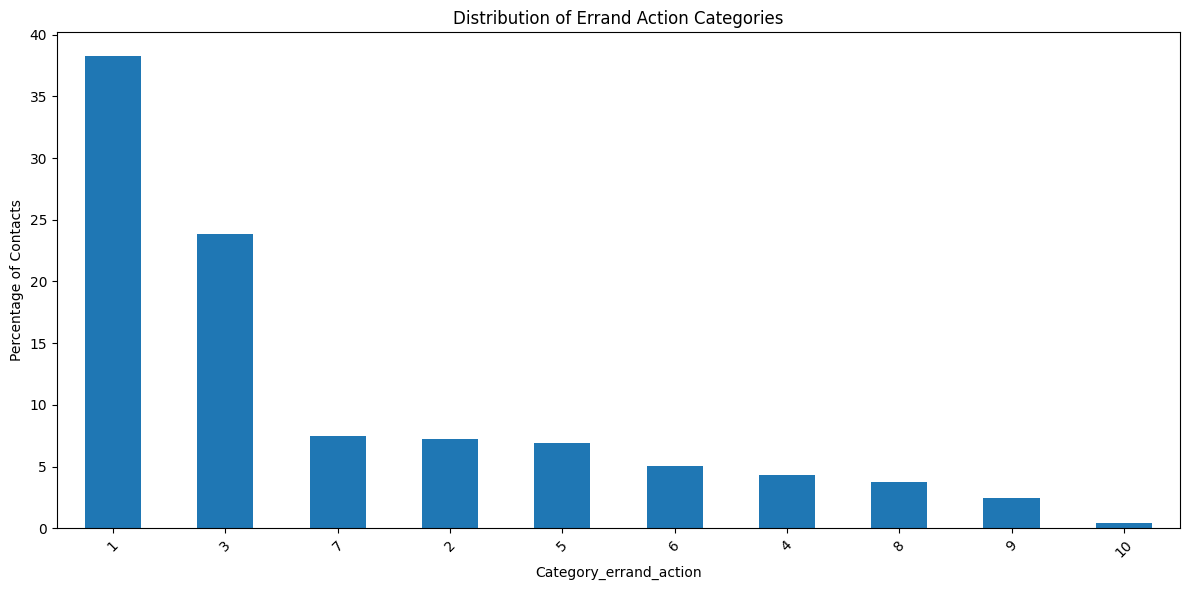

In [83]:
# analyze errand action categories and their percentages
# Function to map actions
def categorize_errand_action(action):
    if pd.isna(action):
        return None
    prefix = action.split(':')[0].split('.')[0]
    return prefix

merged_df['errand_action_category'] = merged_df['errand_action'].apply(categorize_errand_action).sort_values(ascending=False)
category_counts = merged_df['errand_action_category'].value_counts()
category_percentages = (category_counts / len(merged_df) * 100).round(2)

# Create bar plot of percentages
plt.figure(figsize=(12,6))
category_percentages.head(10).plot(kind='bar')
plt.title('Distribution of Errand Action Categories')
plt.xlabel('Category_errand_action')
plt.ylabel('Percentage of Contacts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Time-Based Patterns

2885296
errand_created_at
2024-03-05    0.955985
2024-03-13    0.934739
2024-03-06    0.918069
2024-03-27    0.908642
2024-03-26    0.908399
dtype: float64


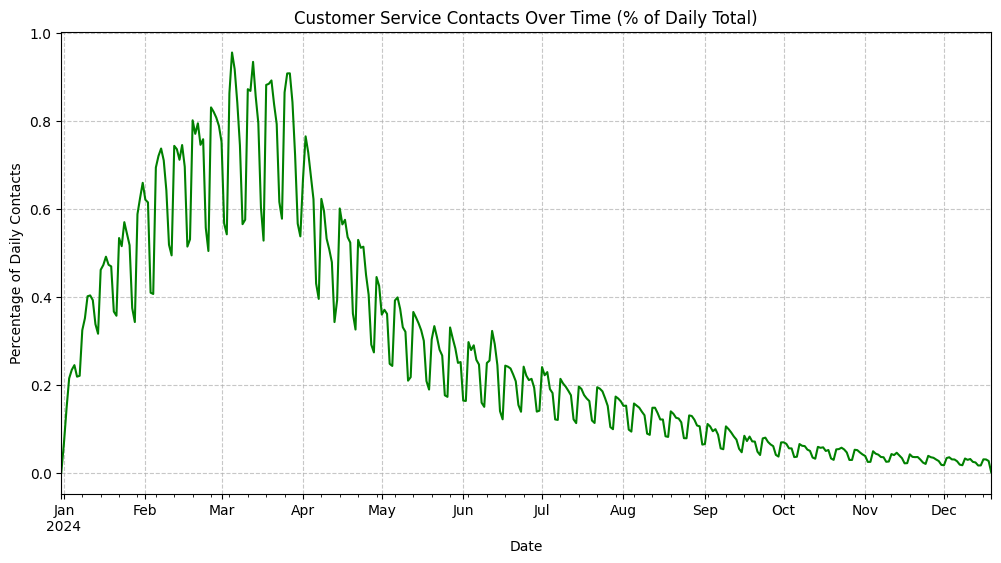

In [63]:
# Group data by date and count contacts
# When resampling by day, we should calculate percentages relative to that day's total
time_series = merged_df.resample('D', on='errand_created_at').size()
daily_total = time_series.sum()
print(daily_total)
percentages = (time_series / daily_total) * 100

# top 5 days with most contacts
print(percentages.sort_values(ascending=False).head(5))

# Visualize the trend over time
percentages.plot(figsize=(12, 6), color='green')
plt.xlabel('Date')
plt.ylabel('Percentage of Daily Contacts')
plt.title('Customer Service Contacts Over Time (% of Daily Total)')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()


/var/folders/6p/5mzp7fyd4mgchv364j3jy2jr0000gn/T/ipykernel_91828/87639311.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_analysis = merged_df.groupby('day_of_week').size()


day_of_week
Tuesday      16.45
Wednesday    16.45
dtype: float64
hour_of_day
15    6.46
14    6.20
11    6.17
16    6.16
12    6.15
dtype: float64


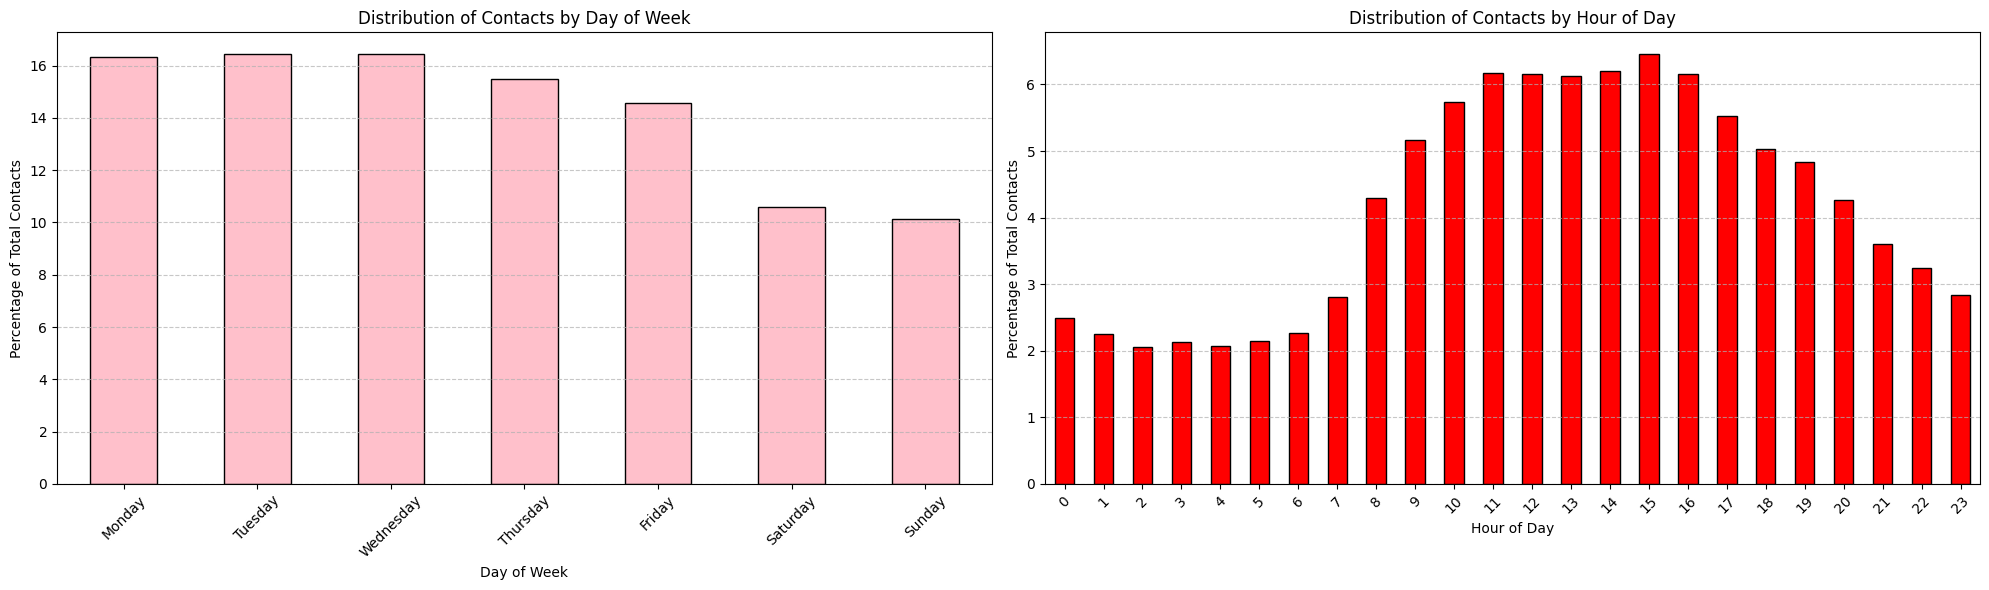

In [82]:
# Create a custom order for days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

merged_df['day_of_week'] = pd.Categorical(merged_df['errand_created_at'].dt.day_name(), 
                                        categories=day_order, 
                                        ordered=True)

# Hour of day analysis
merged_df['hour_of_day'] = merged_df['errand_created_at'].dt.hour

# Calculate counts and percentages by day of week
day_analysis = merged_df.groupby('day_of_week').size()
day_percentages = np.round((day_analysis / day_analysis.sum()) * 100, 2)
# top 2 days with most contacts
print(day_percentages.sort_values(ascending=False).head(2))



# Calculate counts and percentages by hour of day
hour_analysis = merged_df.groupby(merged_df['hour_of_day']).size()
hour_percentages = np.round((hour_analysis / hour_analysis.sum()) * 100, 2)
# top 5 hours with most contacts
print(hour_percentages.sort_values(ascending=False).head(5))


# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot distribution by hour


# Plot distribution by day
day_percentages.plot(kind='bar', color='pink', edgecolor='black', ax=ax1)
ax1.set_title('Distribution of Contacts by Day of Week')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Percentage of Total Contacts')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

hour_percentages.plot(kind='bar', color='red', edgecolor='black', ax=ax2)
ax2.set_title('Distribution of Contacts by Hour of Day')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Percentage of Total Contacts')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Analyze Travel Details
### aim:Focus on improving routes or journey types with high contact volumes.

Top Routes with Most Contacts:
       Origin_Country Destination_Country  route_count  route_percentage
1087           Brazil              Brazil       118036          4.090949
10647             USA                 USA        75187          2.605868
10177        Thailand            Thailand        44897          1.556062
1498           Canada              Canada        29048          1.006760
3725          Germany              Turkey        24882          0.862373
4415            India               India        22191          0.769107
4977            Italy               Italy        20871          0.723357
10953  United Kingdom               India        20711          0.717812
9495            Spain               Spain        18015          0.624373
3712          Germany               Spain        16852          0.584065


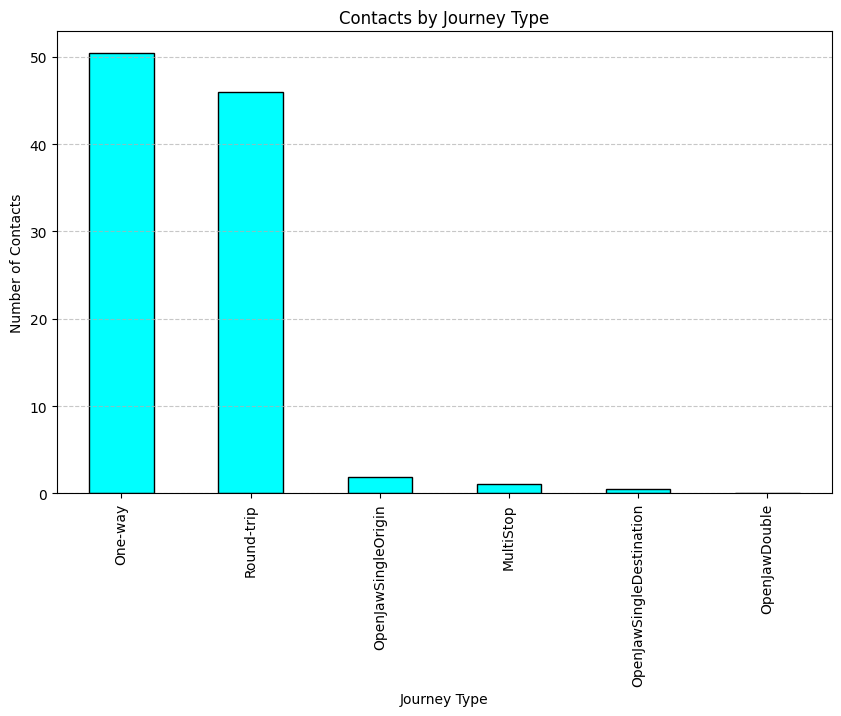

In [110]:
# Group by origin and destination countries, calculate count and percentage
route_contacts = merged_df.groupby(['Origin_Country', 'Destination_Country']).size().reset_index(name='route_count')
route_contacts['route_percentage'] = (route_contacts['route_count'] / route_contacts['route_count'].sum()) * 100
route_contacts = route_contacts.sort_values(by='route_percentage', ascending=False)

# Display results
print("Top Routes with Most Contacts:")
# Display the result
print(route_contacts.head(10))


# Analyze contacts by journey type
journey_contacts = merged_df['Journey_Type_ID'].value_counts()
journey_percentage = (journey_contacts / journey_contacts.sum()) * 100

# Optional visualization
journey_percentage.plot(kind='bar', color='cyan', edgecolor='black', figsize=(10, 6))
plt.xlabel('Journey Type')
plt.ylabel('Number of Contacts')
plt.title('Contacts by Journey Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


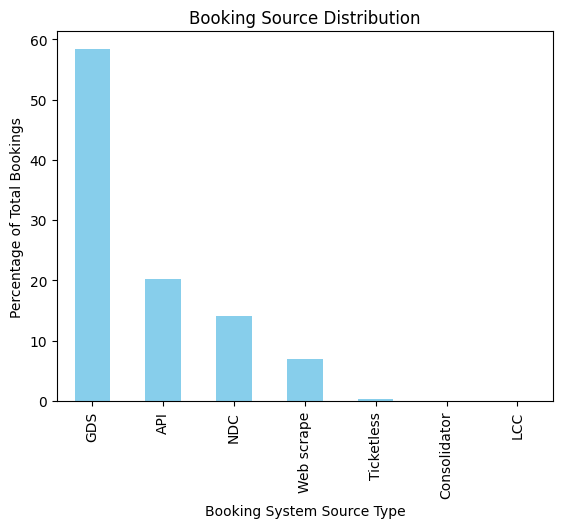

In [215]:
booking_system_contacts = merged_df['booking_system_source_type'].value_counts()

# Distribution of booking sources
booking_system_contacts_pct = (booking_system_contacts / booking_system_contacts.sum()) * 100


booking_system_contacts_pct.plot(kind='bar', color='skyblue', title='Booking Source Distribution')
plt.xlabel('Booking System Source Type')
plt.ylabel('Percentage of Total Bookings')
plt.show()

# Analyze the Cancellation of bookings:
### aim:Identify patterns in cancellations, and optimize cancellation policies or change handling.

In [49]:
# change the Is_Canceled to 1 for the rows where cancel_reason is "Schedule Change - refund"
merged_df.loc[(merged_df['Is_Canceled'] == 0) & (merged_df['cancel_reason'] == "Schedule Change - refund"), 'Is_Canceled'] = 1

# Analyze cancellation patterns
cancel_routes_counts = merged_df[merged_df['Is_Canceled'] == 1].groupby(['Origin_Country', 'Destination_Country']).size()
cancel_routes_percentages = (cancel_routes_counts / len(merged_df[merged_df['Is_Canceled'] == 1]) * 100).round(2).sort_values(ascending=False)

# top 3 routes with most cancellations
print("top 3 routes with most cancellations")
print(cancel_routes_percentages.head(3))


cancel_journeytype_counts = merged_df[merged_df['Is_Canceled'] == 1].groupby(['Journey_Type_ID']).size()
cancel_journeytype_percentages = (cancel_journeytype_counts / len(merged_df[merged_df['Is_Canceled'] == 1]) * 100).round(2).sort_values(ascending=False)

# top 2 routes with most cancellations
print("top 2 journey types with most cancellations")
print(cancel_journeytype_percentages.head(2))


top 3 routes with most cancellations
Origin_Country  Destination_Country
Brazil          Brazil                 4.75
USA             USA                    3.09
India           India                  1.52
dtype: float64
top 2 journey types with most cancellations
Journey_Type_ID
One-way       50.98
Round-trip    45.73
dtype: float64


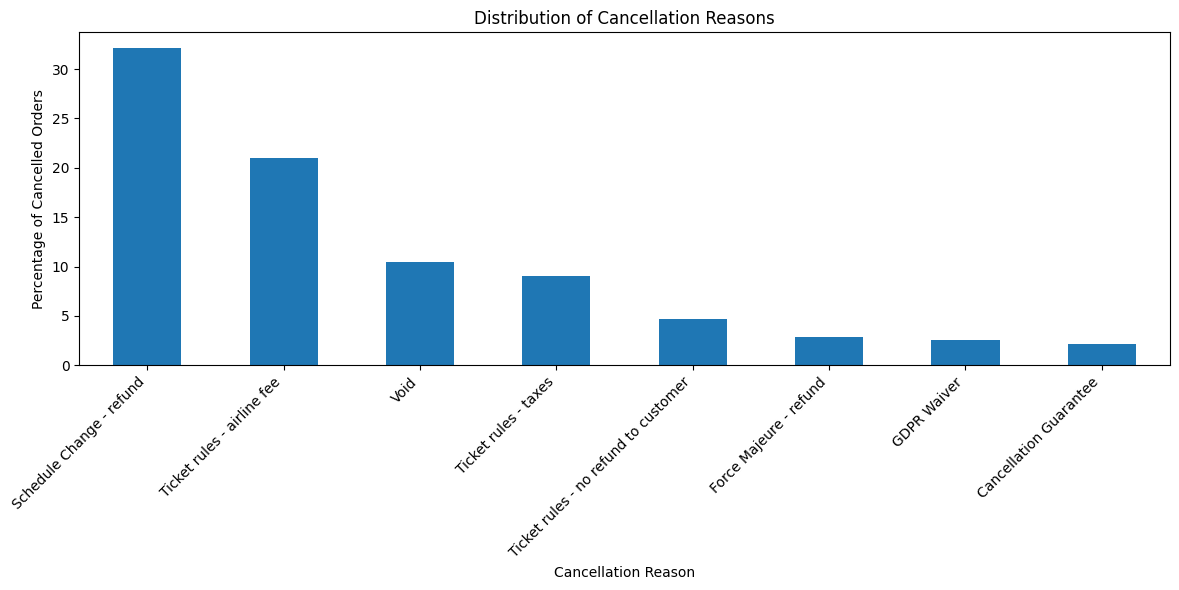

In [240]:
# change the Is_Canceled to 1 for the rows where cancel_reason is "Schedule Change - refund"
merged_df.loc[(merged_df['Is_Canceled'] == 0) & (merged_df['cancel_reason'] == "Schedule Change - refund"), 'Is_Canceled'] = 1

# Calculate cancellation reasons as percentages
cancel_reason_counts = merged_df[merged_df['Is_Canceled'] == 1]['cancel_reason'].value_counts()
cancel_reason_percentages = (cancel_reason_counts / len(merged_df[merged_df['Is_Canceled'] == 1]) * 100).round(2)

# Create bar plot
plt.figure(figsize=(12,6))
cancel_reason_percentages.head(8).plot(kind='bar')
plt.title('Distribution of Cancellation Reasons')
plt.xlabel('Cancellation Reason')
plt.ylabel('Percentage of Cancelled Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


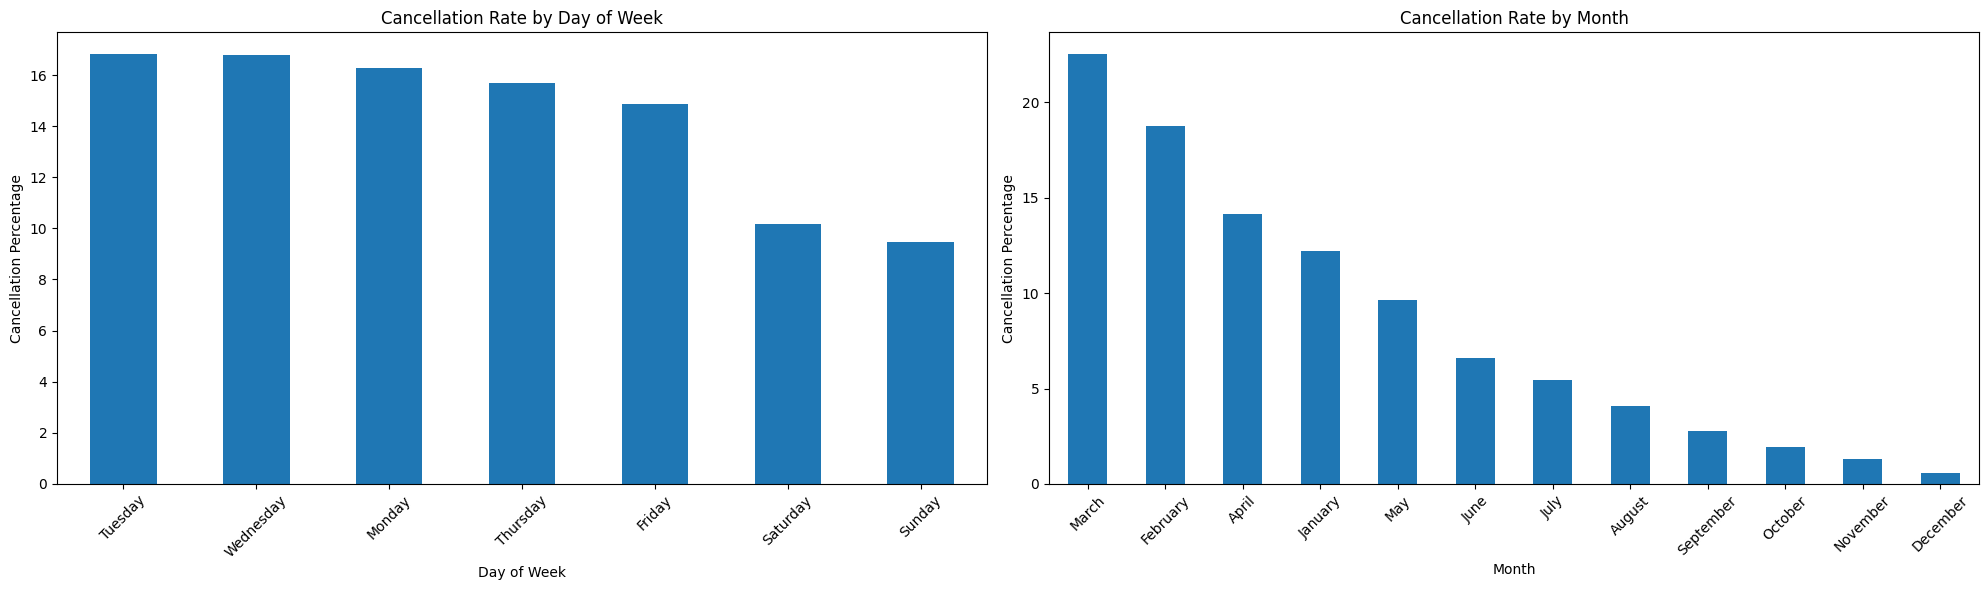

In [253]:
# Calculate cancellation percentages by day of week
day_cancels = merged_df[merged_df['Is_Canceled']==1].groupby('day_of_week').size()
day_totals = day_cancels.sum()
day_percentages = (day_cancels / day_totals * 100).round(2).sort_values(ascending=False)

# Calculate cancellation percentages by month
month_cancels = merged_df[merged_df['Is_Canceled']==1].groupby('month_of_year').size()
month_totals = month_cancels.sum()
month_percentages = (month_cancels / month_totals * 100).round(2).sort_values(ascending=False)

# Create side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

# Plot day of week percentages
day_percentages.plot(kind='bar', ax=ax1)
ax1.set_title('Cancellation Rate by Day of Week')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Cancellation Percentage')
ax1.tick_params(axis='x', rotation=45)

# Plot month percentages 
month_percentages.plot(kind='bar', ax=ax2)
ax2.set_title('Cancellation Rate by Month')
ax2.set_xlabel('Month')
ax2.set_ylabel('Cancellation Percentage')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Analyze the Changing of bookings:
### aim:Identify patterns in changes, and optimize change policies or change handling.

In [50]:
# fixing sth wrong in the dataset
merged_df.loc[(merged_df['Is_Changed'] == 0) & (merged_df['change_reason'].isin(["Schedule change: Primary Alternative", "Cancel part of order"])), 'Is_Changed'] = 1

# Analyze change patterns
change_routes_counts = merged_df[merged_df['Is_Changed'] == 1].groupby(['Origin_Country', 'Destination_Country']).size()
change_routes_percentages = (change_routes_counts / len(merged_df[merged_df['Is_Changed'] == 1]) * 100).round(2).sort_values(ascending=False)

# top 3 routes with most changes
print("top 3 routes with most changes")
print(change_routes_percentages.head(3))


change_journeytype_counts = merged_df[merged_df['Is_Changed'] == 1].groupby(['Journey_Type_ID']).size()
change_journeytype_percentages = (change_journeytype_counts / len(merged_df[merged_df['Is_Changed'] == 1]) * 100).round(2).sort_values(ascending=False)

# top 2 journey types with most changes
print("top 2 journey types with most changes")
print(change_journeytype_percentages.head(2))


top 3 routes with most changes
Origin_Country  Destination_Country
Brazil          Brazil                 3.05
USA             USA                    1.78
Canada          Canada                 1.08
dtype: float64
top 2 journey types with most changes
Journey_Type_ID
Round-trip    49.28
One-way       46.08
dtype: float64


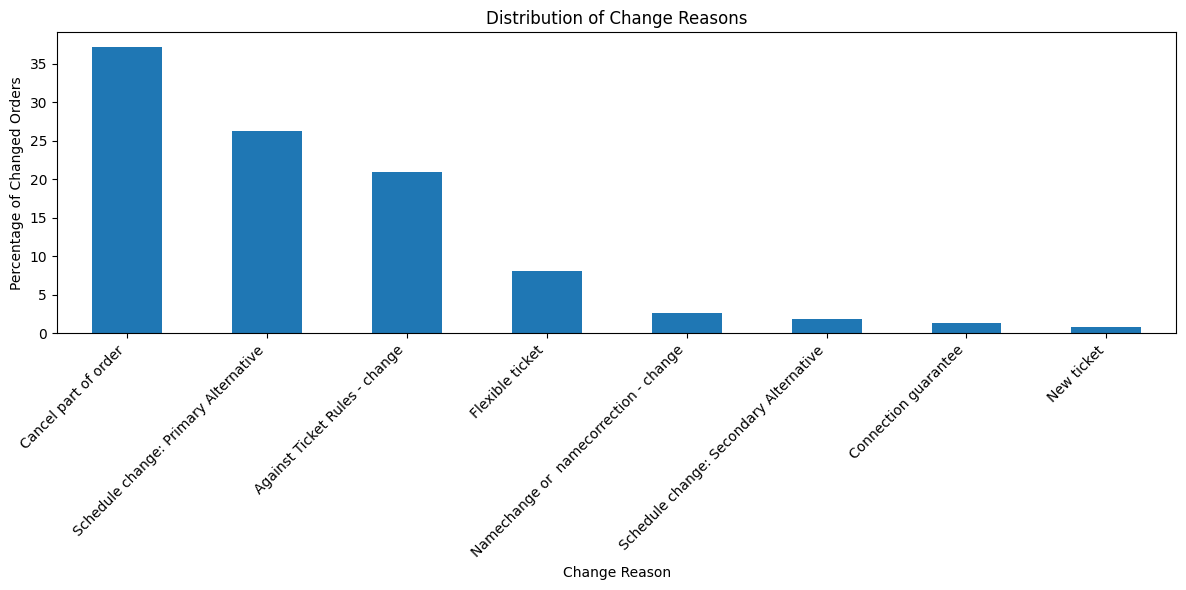

In [244]:
# change the Is_Changed to 1 for the rows where change_reason is "Schedule change: Primary Alternative "
merged_df.loc[(merged_df['Is_Changed'] == 0) & (merged_df['change_reason'].isin(["Schedule change: Primary Alternative", "Cancel part of order"])), 'Is_Changed'] = 1
# Calculate change reasons as percentages
change_reason_counts = merged_df[merged_df['Is_Changed'] == 1]['change_reason'].value_counts()
change_reason_percentages = (change_reason_counts / len(merged_df[merged_df['Is_Changed'] == 1]) * 100).round(2)

# Create bar plot
plt.figure(figsize=(12,6))
change_reason_percentages.head(8).plot(kind='bar')
plt.title('Distribution of Change Reasons')
plt.xlabel('Change Reason')
plt.ylabel('Percentage of Changed Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


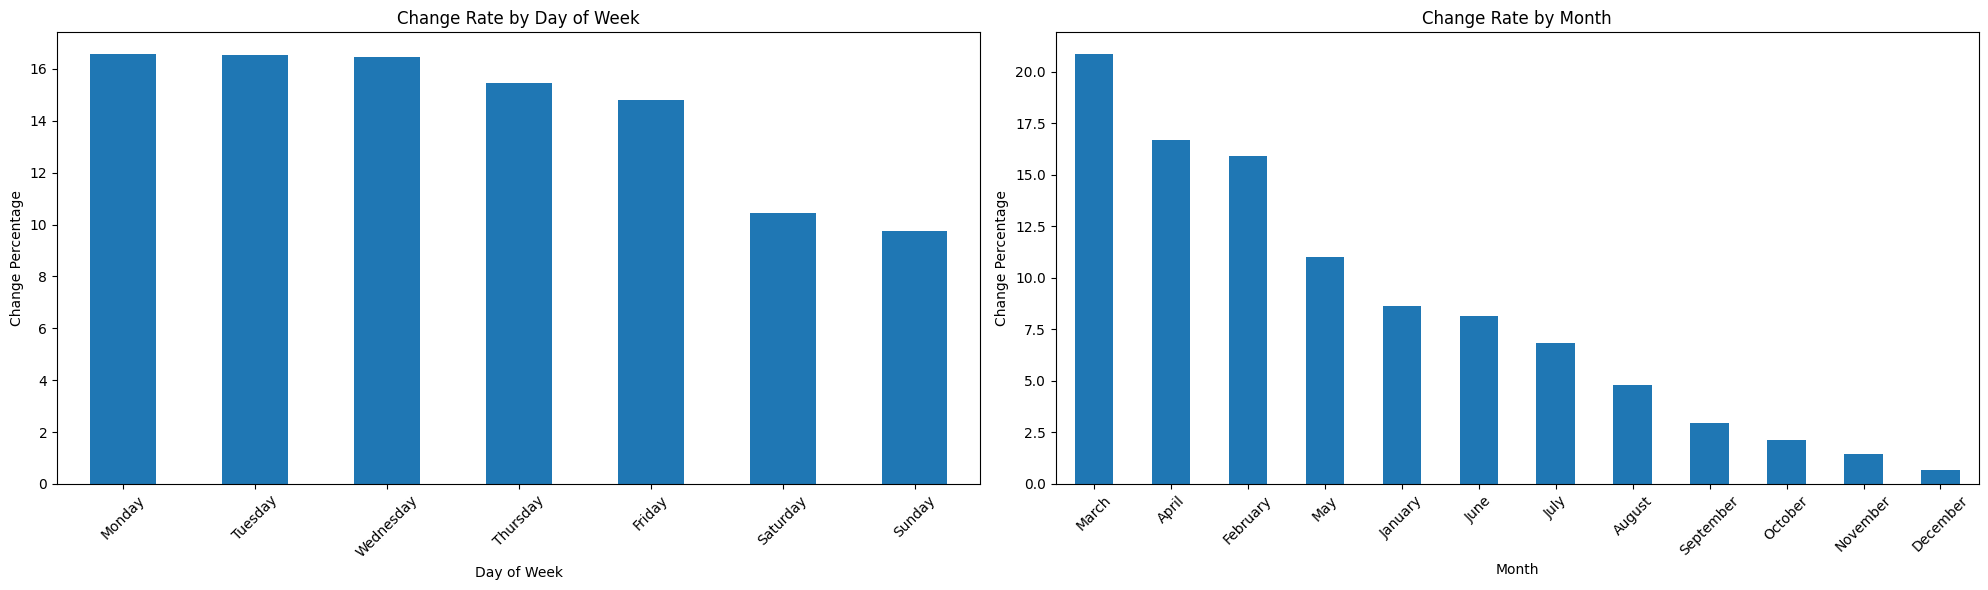

In [254]:
# Calculate change percentages by day of week
day_changes = merged_df[merged_df['Is_Changed']==1].groupby('day_of_week').size()
day_totals = day_changes.sum()
day_percentages = (day_changes / day_totals * 100).round(2).sort_values(ascending=False)

# Calculate change percentages by month
month_changes = merged_df[merged_df['Is_Changed']==1].groupby('month_of_year').size()
month_totals = month_changes.sum()
month_percentages = (month_changes / month_totals * 100).round(2).sort_values(ascending=False)

# Create side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

# Plot day of week percentages
day_percentages.plot(kind='bar', ax=ax1)
ax1.set_title('Change Rate by Day of Week')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Change Percentage')
ax1.tick_params(axis='x', rotation=45)

# Plot month percentages 
month_percentages.plot(kind='bar', ax=ax2)
ax2.set_title('Change Rate by Month')
ax2.set_xlabel('Month')
ax2.set_ylabel('Change Percentage')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Analyze Financial
### aim:Optimize booking processes or customer support for high-value bookings and frequent customer groups.

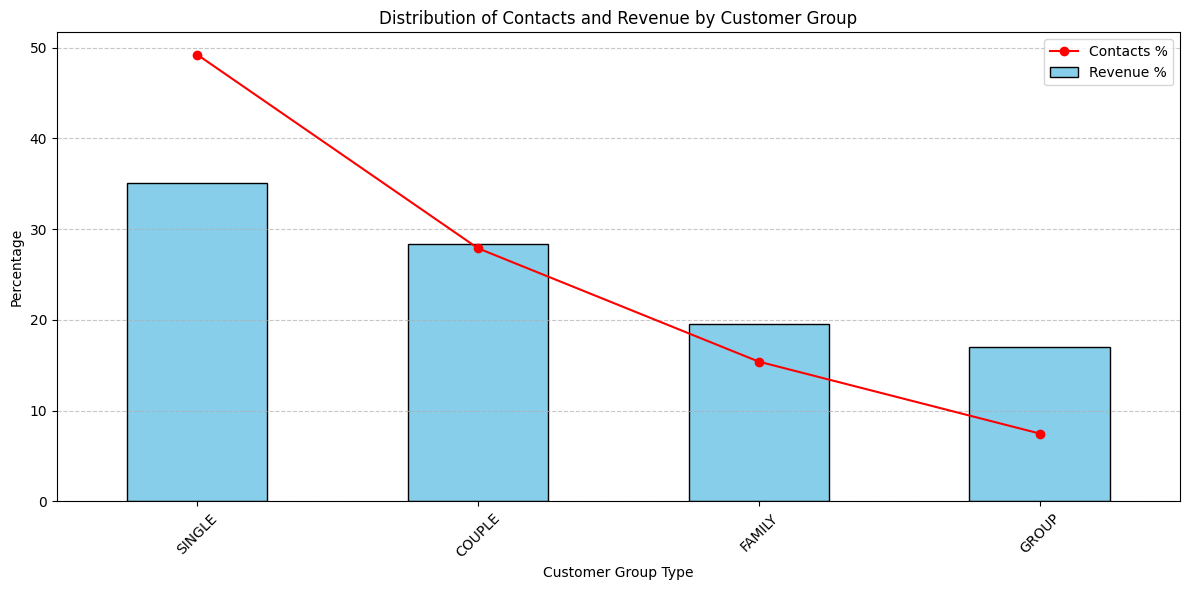

In [53]:
# Analyze contacts by customer group type and revenue
customer_group_contacts = merged_df['Customer_Group_Type'].value_counts()
customer_group_percentages = (customer_group_contacts / customer_group_contacts.sum() * 100).sort_values(ascending=False)
revenue_by_group = merged_df.groupby('Customer_Group_Type')['Revenue'].sum()
revenue_percentages = (revenue_by_group / revenue_by_group.sum() * 100).sort_values(ascending=False)

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot revenue percentages and contacts percentages
revenue_percentages.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax, label='Revenue %')
customer_group_percentages.plot(kind='line', color='red', marker='o', ax=ax, label='Contacts %')

# Customize plot
ax.set_xlabel('Customer Group Type')
ax.set_ylabel('Percentage')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend()

# Add title and adjust layout
plt.title('Distribution of Contacts and Revenue by Customer Group')
plt.tight_layout()
plt.show()
